In [2]:
import pandas as pd
import networkx as nx
import numpy as np
from matplotlib import pyplot as plt
import matplotlib
from tqdm import tqdm
import plotly.graph_objects as go
import seaborn as sns
import geopandas as gpd
from matplotlib.colors import TwoSlopeNorm  # Use CenteredNorm for newer matplotlib versions
from scipy.stats import pearsonr
from adjustText import adjust_text
matplotlib.rc('font', family='Arial') 
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
import matplotlib.patches as mpatches

In [56]:
pop_df=pd.read_csv(r'C:\Users\Yasaman\Downloads\World_bank_population.csv',skiprows=3)
pop_df=pop_df[['Country Code','2003','2018']].dropna()
pop_df['2018']=pop_df['2018'].astype(int)
possible_countries=pop_df.query(" `2018` >=1000000")['Country Code'].values
possible_countries=[x.lower() for x in possible_countries]

In [155]:
physical_sciences=[ 'MATH', 'ENGI', 'PHYS', 'COMP','MULT']
df_fund=pd.read_csv(r"C:\Users\Yasaman\Downloads\Mentioned-Funding-fractional counting.csv")
df_fund=df_fund[~(df_fund['subjarea'].isin(physical_sciences))]
df_fund=df_fund.groupby(['year', 'country', 'funding_country','subjarea']).sum().reset_index()

df_fund=df_fund[(df_fund['year'].isin(np.arange(2003,2019,1)))&(df_fund['funding_country'].isin(possible_countries)) &(df_fund['country'].isin(possible_countries))].reset_index(drop=True)
df_fund['is_internal']=df_fund['funding_country']==df_fund['country']
df_fund['year_arabspring']=df_fund['year'].apply(lambda x: 'before' if x>=2003 and x<=2010 else 'after' )

In [168]:
 def plot_BC(ax):   
    to_plot_a=df_fund.groupby(['year_arabspring','is_internal','country'])['aggregated_value'].sum().reset_index()
    to_plot_a=to_plot_a.rename(columns={'country':'Mention_country','aggregated_value':'count'})
    Country_list = {'Egypt':'EGY', 'Tunisia':'TUN', 'Libya':'LBY', 'Syria':'SYR', 'Yemen':'YEM',
                    'Bahrain':'BHR', 'Jordan':'JOR', 'Kuwait':'KWT', 'Morocco':'MAR', 'Oman':'OMN'}
    rev_Country_list = {Country_list[key].lower(): key for key in Country_list}
    country_names = list(Country_list.keys())
    custom_colors = [f'C{i}' for i in range(10)]
    Titles=['Domestic', 'Foreign']

    for i, is_internal in enumerate([True, False]):
        subset = to_plot_a.query(f'is_internal == {is_internal} and Mention_country in @abbr')
        subset['Mention_country'] = subset['Mention_country'].map(rev_Country_list)
        subset['sorted_order'] = subset['Mention_country'].apply(lambda x: country_names.index(x))
        subset = subset.sort_values('sorted_order').drop(columns=['sorted_order'])

        # Reset the index if needed
        subset.reset_index(drop=True, inplace=True)
        x_labels = subset['Mention_country'].unique()
        x = np.arange(len(x_labels))  # X positions for the bars
        subset['count']/=8
        width = 0.4  # Width of each bar
        before_data = subset[subset['year_arabspring'] == 'before'][['Mention_country','count']].set_index('Mention_country').to_dict()['count']
        for c in country_names:
            if c not in before_data:
                before_data[c]=0
        before_data=list(before_data.values())
        after_data = subset[subset['year_arabspring'] == 'after'][['Mention_country','count']].set_index('Mention_country').to_dict()['count']
        for c in country_names:
            if c not in after_data:
                after_data[c]=0
        after_data=list(after_data.values())
        ax[i].bar(
            x - width / 2, 
            before_data, 
            width=width, 
            color=custom_colors, 
            label='Before'
        )
        
        # Bars for 'after' with dashed patterns
        ax[i].bar(
            x + width / 2, 
            after_data, 
            width=width, 
            color='none', 
            edgecolor=custom_colors, 
            linewidth=1.5, 
            hatch='//', 
            label='After'
        )
        medians=to_plot_a.query(f'is_internal == {is_internal}').groupby('year_arabspring')['count'].median().to_dict()

        ax[i].axhline(medians['before']/8, color='k')
        ax[i].axhline(medians['after']/8, color='k', linestyle='--')
        
        # Set x-axis labels and title
        ax[i].set_xticks(x)
        ax[i].set_xticklabels(x_labels, rotation=90)
        ax[i].set_title(Titles[i])
        #ax[i].set_ylim(0, 3500)
    ax[0].set_ylabel('Average Domestic Yearly Funding')
    ax[1].set_ylabel('Average Foriegn Yearly Funding')

In [175]:
def plot_A(ax):
    df=pd.read_csv(r"C:\Users\Yasaman\Downloads\Mentioned-Funding-fractional counting.csv")
    df=df[df['country'].isin(possible_countries)]
    df=df.rename(columns={'year':'Year', 'aggregated_value':'count', 'country':'Mention_country', 'funding_country':'Aff_country'})
    Country_list={'Egypt':'EGY', 'Tunisia':'TUN','Libya':'LBY','Syria':'SYR','Yemen':'YEM','Bahrain':'BHR','Jordan':'JOR','Kuwait':'KWT','Morocco':'MAR','Oman':'OMN'}
    abbr=[country.lower() for country in Country_list.values()]
    physical_sciences=[ 'MATH', 'ENGI', 'PHYS', 'COMP']
    df=df[~df['subjarea'].isin(physical_sciences)]
    df=df.groupby(['Year', 'Mention_country', 'Aff_country'])['count'].sum().reset_index()
    
    country_codes=pd.read_csv(r"C:\Users\Yasaman\Downloads\iso3.csv")
    country_codes['iso3']=[c.lower() for c in country_codes['iso3']]
    Map={country_codes.iloc[c]['iso3']: country_codes.iloc[c]['name'] for c in range(len(country_codes))}
    Map['irn']='Iran'
    Map['usa']='USA'
    Map['gbr']='UK'
    Map['syr']='Syria'
    
    # Define year ranges for "before" and "after" data.
    years_before = np.arange(2003, 2011, 1)
    years_after = np.arange(2011, 2019, 1)
    


    # Function to calculate summary statistics for given years and data.
    def summarize_years(df, years, abbr):
        # Filter the DataFrame for the given years range.
        df_filtered = df[(df['Year'].isin(years))]
        # Sum of counts by affiliation country.
        summary_df = df_filtered.groupby(['Aff_country','Mention_country'])['count'].sum().reset_index()

        return summary_df.fillna(0)  # Fill NaN with 0 if any.

    # Apply the function to both year ranges.
    before_df = summarize_years(df, years_before, abbr)
    before_df = before_df.add_suffix('_before')

    after_df = summarize_years(df, years_after, abbr)
    after_df = after_df.add_suffix('_after')


    full_df = before_df.merge(after_df, left_on=['Aff_country_before','Mention_country_before'], right_on=['Aff_country_after','Mention_country_after'], how='outer')
    full_df.fillna(0, inplace=True)
    full_df['Mention_country'] = np.where(full_df['Mention_country_before'] != 0, full_df['Mention_country_before'], full_df['Mention_country_after'])
    full_df['Aff_country'] = np.where(full_df['Aff_country_before'] != 0, full_df['Aff_country_before'], full_df['Aff_country_after'])
    full_df.drop(columns=['Aff_country_before','Mention_country_before','Mention_country_after','Aff_country_after'], inplace=True)
    
    result_df=full_df.groupby('Mention_country')[['count_after', 'count_before']].sum().reset_index()

    result_df['count_after']/=len(years_before)
    result_df['count_before']/=len(years_before)
    result_df['Absolute difference']=result_df['count_after']-result_df['count_before']

    col='Absolute difference'
    markers=['o', 'v', '^', 'x', 's', 'd', '>', '<', 'p', '+']
    copy_df = result_df[result_df['Mention_country'].isin(abbr)]
    copy_df=copy_df.sort_values(by=col, ascending=True).reset_index(drop=True)

    country_names=['egy','tun', 'lby', 'syr', 'yem', 'bhr', 'jor', 'kwt', 'mar', 'omn']
   # sns.boxplot(result_df, y='Absolute difference', ax=ax,log_scale=(False,True), color='lightgrey')
    ax.axhspan(result_df[col].quantile(0.25), result_df[col].quantile(0.75), alpha=0.2 , color='grey', label='IQR')
    ax.axhline(result_df[col].mean(), linestyle=':', label='mean', color='k')
    ax.axhline(result_df[col].median(), linestyle='--', label='median', color='k')
    
    for i, country in enumerate(country_names):
        val=copy_df[copy_df['Mention_country']==country][col].values[0]
        index=copy_df[copy_df['Mention_country']==country][col].index[0]
        ax.scatter([index], [val], color=f'C{i}', marker=markers[i],zorder=3, s=50)
        ax.axvline(index, color=f'C{i}', ymin=0, ymax=val/370)
    #ax.stem(countries ,values, basefmt=" ", use_line_collection=True,orientation='horizontal')  # 'basefmt' hides the baseline

    ax.legend( frameon=False)
    ax.set_xticks(np.arange(len(copy_df)))
    ax.set_xticklabels([Map[j] for j in copy_df['Mention_country'].values])
    ax.set_ylim(0, 370)
    ax.set_ylabel('$\Delta F_{tot}^i$', fontsize=15)

C:\Users\Yasaman\AppData\Local\Temp\ipykernel_46284\3071400505.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset['Mention_country'] = subset['Mention_country'].map(rev_Country_list)
C:\Users\Yasaman\AppData\Local\Temp\ipykernel_46284\3071400505.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset['sorted_order'] = subset['Mention_country'].apply(lambda x: country_names.index(x))
C:\Users\Yasaman\AppData\Local\Temp\ipykernel_46284\3071400505.py:13: SettingWithCopyWarning: 
A value is trying 

Pearson Correlation Coefficient: 0.9525949606586557
P-value: 2.966740289821382e-47


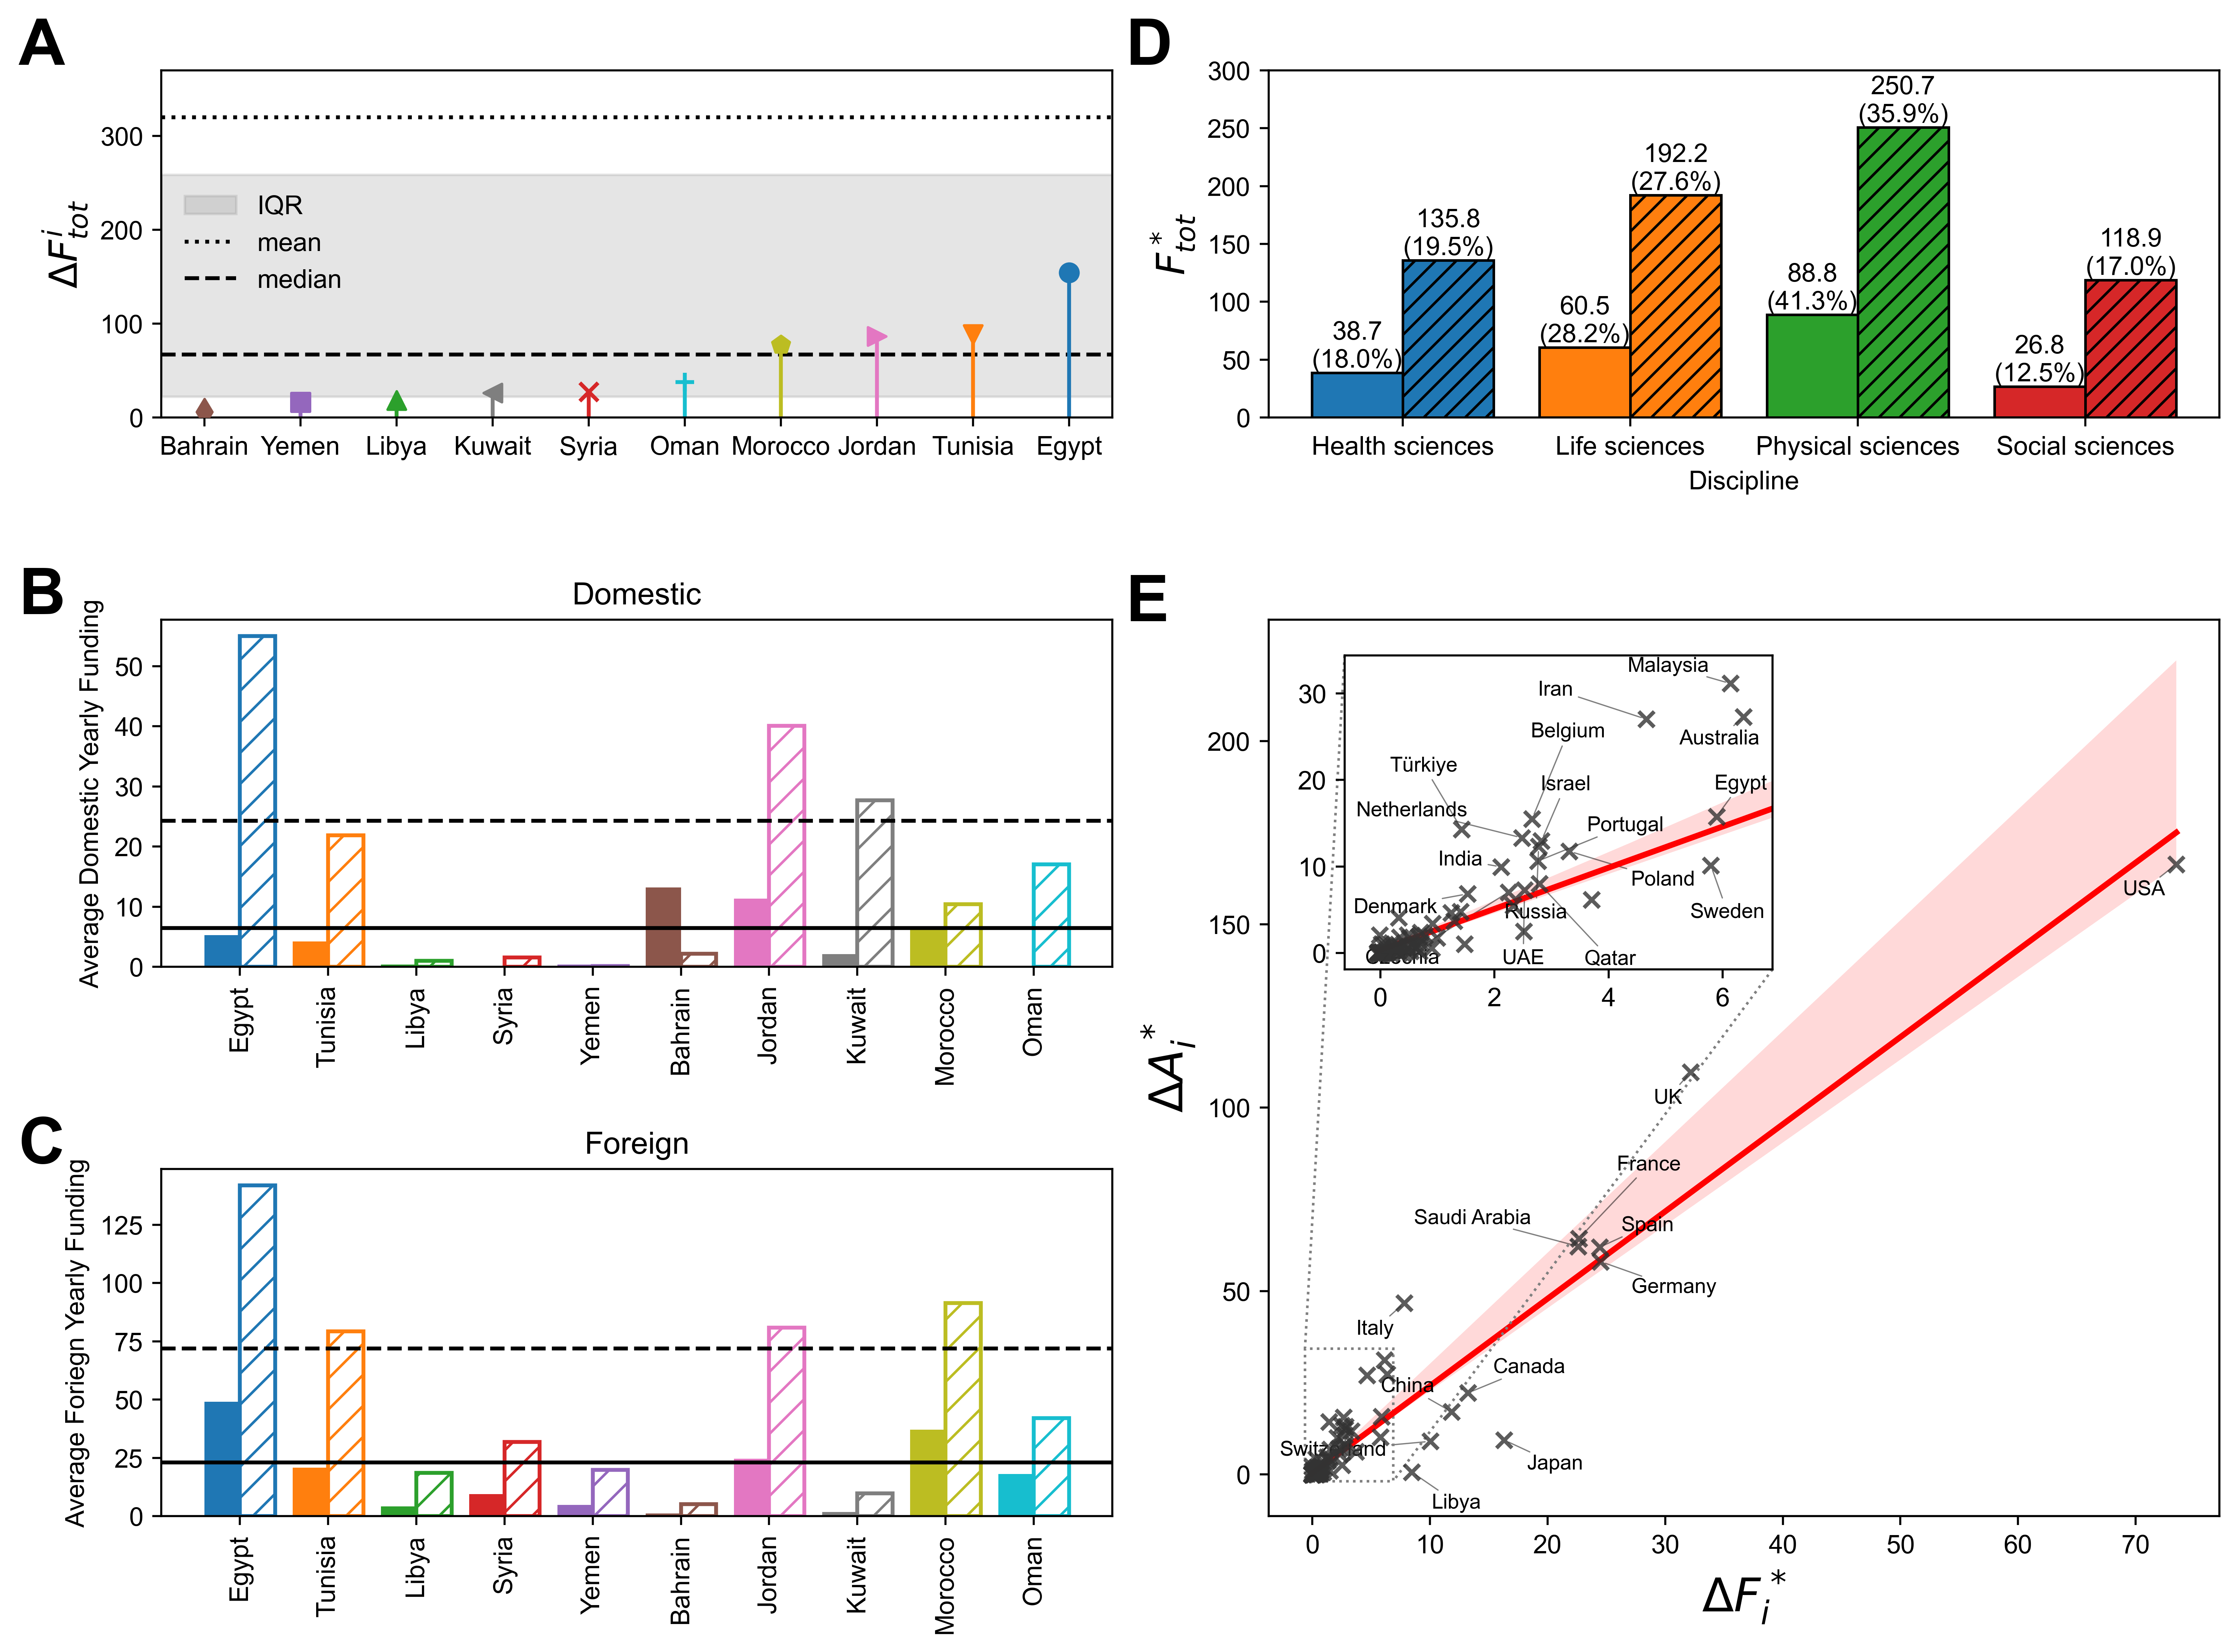

In [179]:
#### Create a new figure with custom subplot layout
fig = plt.figure(figsize=(12, 9), dpi=500)

# Create grid specification for subplots
gs = fig.add_gridspec(3, 2)

ax1 = fig.add_subplot(gs[0, 0])
ax1.text(-0.15, 1.15, 'A', transform=ax1.transAxes, verticalalignment='top', fontsize=25,fontweight='bold')
plot_A(ax1)

ax2 = fig.add_subplot(gs[1, 0])
ax2.text(-0.15, 1.15, 'B', transform=ax2.transAxes, verticalalignment='top', fontsize=25,fontweight='bold')



ax3 = fig.add_subplot(gs[2, 0])
ax3.text(-0.15, 1.15, 'C', transform=ax3.transAxes, verticalalignment='top', fontsize=25,fontweight='bold')

plot_BC([ax2,ax3])




ax4 = fig.add_subplot(gs[0, 1])
ax4.text(-0.15, 1.15, 'D', transform=ax4.transAxes, verticalalignment='top', fontsize=25,fontweight='bold')
plot_D(ax4)


ax5 = fig.add_subplot(gs[1:, 1])
ax5.text(-0.15, 1.05, 'E', transform=ax5.transAxes, verticalalignment='top', fontsize=25,fontweight='bold')
ins = ax5.inset_axes([0.08,0.61,0.45,0.35])


plot_E(ax5, ins)

fig.tight_layout()

In [1]:
def find_cat(subject):
    social_sciences=['PSYC', 'SOCI', 'DECI', 'ARTS', 'ECON', 'BUSI']
    health_sciences=['MEDI', 'NURS', 'DENT', 'HEAL', 'VETE']
    physical_sciences=['CHEM', 'EART', 'ENER', 'CENG',  'ENVI','MATE']
    life_sciences=['PHAR', 'NEUR', 'AGRI', 'IMMU', 'BIOC']
    if subject in social_sciences:
        return 'Social sciences'
    elif  subject in health_sciences:
        return 'Health sciences'
    elif subject in physical_sciences:
        return 'Physical sciences'
    elif subject in life_sciences:
        return 'Life sciences'
    else:
        return subject

In [129]:
def plot_D(ax4):   
    
    fund_subj_before=df_fund.query('(2003<=year<2011) &(country in @abbr)').groupby(['subjarea'])['aggregated_value'].sum().reset_index()
    fund_subj_before['subjarea']=fund_subj_before['subjarea'].apply(find_cat)
    fund_subj_before=fund_subj_before.groupby('subjarea').sum().reset_index().round(1)


    fund_subj_after=df_fund.query('(2011<=year<2019)&(country in @abbr)').groupby(['subjarea'])['aggregated_value'].sum().reset_index()
    fund_subj_after['subjarea']=fund_subj_after['subjarea'].apply(find_cat)
    fund_subj_after=fund_subj_after.groupby('subjarea').sum().reset_index().round(1)

    # Calculate the shares
    total_before = sum(fund_subj_before['aggregated_value'])
    total_after = sum(fund_subj_after['aggregated_value'])

    shares_before = [value / total_before * 100 for value in fund_subj_before['aggregated_value']]
    shares_after = [value / total_after * 100 for value in fund_subj_after['aggregated_value']]

    bars_before = ax4.bar([0, 2, 4, 6], fund_subj_before['aggregated_value']/8, color=['C0', 'C1', 'C2', 'C3'],edgecolor='k')
    bars_after = ax4.bar([0.8, 2.8, 4.8, 6.8], fund_subj_after['aggregated_value']/8, color=['C0', 'C1', 'C2', 'C3'], hatch='///',edgecolor='k')

    # Annotate bars with numbers and shares
    for i, (bar_before, bar_after) in enumerate(zip(bars_before, bars_after)):
        height_before = bar_before.get_height().round(1)
        height_after = bar_after.get_height().round(1)
        
        # Number and share for 'before' bars
        ax4.text(bar_before.get_x() + bar_before.get_width() / 2.0, height_before, 
                f'{height_before}\n({shares_before[i]:.1f}%)', ha='center', va='bottom')

        # Number and share for 'after' bars
        ax4.text(bar_after.get_x() + bar_after.get_width() / 2.0, height_after, 
                f'{height_after}\n({shares_after[i]:.1f}%)', ha='center', va='bottom')

    ax4.set_xticks([0.4, 2.4, 4.4, 6.4], ['Health sciences', 'Life sciences', 'Physical sciences', 'Social sciences'])

    ax4.set_xlabel('Discipline')
    ax4.set_ylabel('$F^*_{tot}$', fontsize=15)
    ax4.set_ylim(0, 300)
    handles=[]
    handles.append(mpatches.Patch(facecolor='white', label='Before Arab spring\n   2003-2010', edgecolor='k'))
    handles.append(mpatches.Patch(facecolor='white', label='After Arab spring\n    2011-2018', hatch='////',edgecolor='k'))


In [178]:
def plot_E(ax1, ins):

    def find_df_fund(df, start_year, middle_year1, middle_year2, end_year):
        df=df.rename(columns={'year':'Year', 'aggregated_value':'count', 'country':'Mention_country'})
        before_df=df[(df['Year'].isin(np.arange(start_year, middle_year1, 1)))&(df['Mention_country'].isin(abbr))].groupby(by=['subjarea','Mention_country' ,'funding_country'])['count'].sum().reset_index().rename(columns={'count':'target_count_before'})

        after_df=df[(df['Year'].isin(np.arange(middle_year2, end_year, 1)))&(df['Mention_country'].isin(abbr))].groupby(by=['subjarea','Mention_country' ,'funding_country'])['count'].sum().reset_index().rename(columns={'count':'target_count_after'})

        new_df=before_df.merge(after_df, on=['funding_country', 'Mention_country', 'subjarea'], how='outer').fillna(0)
        return new_df.rename(columns={'funding_country':'source_country'})

    def find_df_attention(df, start_year, middle_year1, middle_year2, end_year):
        Country_list={'Egypt':'EGY', 'Tunisia':'TUN','Libya':'LBY','Syria':'SYR','Yemen':'YEM','Bahrain':'BHR','Jordan':'JOR','Kuwait':'KWT','Morocco':'MAR','Oman':'OMN'}
        rev_Country_list={Country_list[key]: key for key in Country_list}
        abbr=[country.lower() for country in Country_list.values()]
        df=df.rename(columns={'year':'Year', 'aggregated_value':'count', 'country':'Mention_country'})
        before_df=df[(df['Year'].isin(np.arange(start_year, middle_year1, 1)))&(df['Mention_country'].isin(abbr))].groupby(by=['subjarea','Mention_country' ,'affiliation_country'])['count'].sum().reset_index().rename(columns={'count':'target_count_before'})

        after_df=df[(df['Year'].isin(np.arange(middle_year2, end_year, 1)))&(df['Mention_country'].isin(abbr))].groupby(by=['subjarea','Mention_country' ,'affiliation_country'])['count'].sum().reset_index().rename(columns={'count':'target_count_after'})

        new_df=before_df.merge(after_df, on=['affiliation_country', 'Mention_country', 'subjarea'], how='outer').fillna(0)
        return new_df.rename(columns={'affiliation_country':'source_country'})
    physical_sciences=[ 'MATH', 'ENGI', 'PHYS', 'COMP']
    df_fund=pd.read_csv(r"C:\Users\Yasaman\Downloads\Mentioned-Funding-fractional counting.csv")
    df_fund=df_fund[~(df_fund['subjarea'].isin(physical_sciences))]
    df_fund=df_fund.groupby(['year', 'country', 'funding_country','subjarea']).sum().reset_index()
    df_attention=pd.read_csv(r"C:\Users\Yasaman\Downloads\Attention-fractional counting.csv")
    df_attention=df_attention[~(df_attention['subjarea'].isin(physical_sciences))]
    df_attention=df_attention.groupby(['year', 'affiliation_country','country','subjarea']).sum().reset_index()


    res_fund=find_df_fund(df_fund, 2003, 2011, 2011, 2019)
    res_attention=find_df_attention(df_attention, 2003, 2011, 2011, 2019)
    res_df=res_attention.merge(res_fund, on=['subjarea', 'Mention_country','source_country'], suffixes=['_attention', '_fund'], how='inner').fillna(0)
    res_df=res_df[res_df['Mention_country']!=res_df['source_country']]

    plot_a_df=res_df.groupby([ 'source_country']).sum().reset_index().drop(columns={'subjarea','Mention_country'})
    plot_a_df['dif_attention']=plot_a_df['target_count_after_attention']-plot_a_df['target_count_before_attention']
    plot_a_df['dif_fund']=plot_a_df['target_count_after_fund']-plot_a_df['target_count_before_fund']
    plot_a_df=plot_a_df[plot_a_df['source_country'].isin(possible_countries)]




    country_codes=pd.read_csv(r"C:\Users\Yasaman\Downloads\iso3.csv")
    country_codes['iso3']=[c.lower() for c in country_codes['iso3']]
    map={country_codes.iloc[c]['iso3']: country_codes.iloc[c]['name'] for c in range(len(country_codes))}
    map['irn']='Iran'
    map['usa']='USA'
    map['gbr']='UK'
    map['rus']='Russia'
    map['syr']='Syria'
    map['are']='UAE'
    plot_a_df=plot_a_df.sort_values(by=['dif_fund'], ascending=False).reset_index(drop=True)
    plot_a_df=plot_a_df[plot_a_df['source_country'].isin(possible_countries)]
    plot_a_df['dif_attention']/=8
    plot_a_df['dif_fund']/=8
    sns.regplot(plot_a_df, x='dif_fund', y='dif_attention' ,marker="x", color=".2", line_kws=dict(color="r"),ax=ax1,  scatter_kws={"zorder":10}, robust=True)
    ax1.set_ylabel(r'$\Delta A_i^*$', fontsize=18)
    ax1.set_xlabel(r'$\Delta F_i^*$', fontsize=18)

    sns.regplot(plot_a_df, x='dif_fund', y='dif_attention' ,marker="x", color=".2", line_kws=dict(color="r"),ax=ins,  scatter_kws={"zorder":10}, robust=True)
    ins.set_ylabel(r'', fontsize=10)
    ins.set_xlabel(r'', fontsize=10)
    ins.set_xlim(-5/8, 55/8)
    ins.set_ylim(-15/8, 275/8)




    points=[]
    # Annotate each point
    for line in range(sum(plot_a_df['dif_fund']>55/8)):

        x = plot_a_df.dif_fund[line]
        y = plot_a_df.dif_attention[line]
        label =map[plot_a_df.source_country[line]]
        points+=[ax1.text(x, y, label,
                        fontsize=8, ha='center', va='center')]

    adjust_text(points, arrowprops=dict(arrowstyle="-", color='k', lw=0.5, alpha=.5), expand=(1.5, 2.5))        

    points2=[]
    # Annotate each point
    for line in plot_a_df[((plot_a_df['dif_fund']<55/8)&(plot_a_df['dif_attention']>50/8))].index:

        x = plot_a_df.dif_fund[line]
        y = plot_a_df.dif_attention[line]
        label =map[plot_a_df.source_country[line]]
        points2+=[ins.text(x, y, label,
                        fontsize=8, ha='center', va='center')]

    adjust_text(points2, arrowprops=dict(arrowstyle="-", color='k', lw=0.5, alpha=.5), expand=(1.5, 2), ax=ins)        


    correlation_coefficient, p_value = pearsonr(plot_a_df['dif_fund'], plot_a_df['dif_attention'])
    print("Pearson Correlation Coefficient:", correlation_coefficient)
    print("P-value:", p_value)

    #ax1.indicate_inset_zoom(ins, edgecolor="black")

    mark_inset(ax1, ins, loc1=2, loc2=4, fc="none", ec="0.5", linestyle=':')
